Starting Portfolio Value: 1000.00
2000-01-24, Close, 24.10
2000-01-25, Close, 25.10
2000-01-25, BUY CREATE, 25.10
2000-01-26, BUY EXECUTED, Price: 25.24, Cost: 252.40, Comm 0.00, Size: 10
2000-01-26, Close, 24.49
2000-01-27, Close, 23.04
2000-01-27, SELL CREATE, 23.04
2000-01-28, SELL EXECUTED, Price: 22.90, Cost: 252.40, Comm 0.00, Size: -10
2000-01-28, OPERATION PROFIT, GROSS -23.40, NET -23.40
2000-01-28, Close, 21.07
2000-01-31, Close, 22.22
2000-02-01, Close, 24.02
2000-02-02, Close, 24.16
2000-02-02, BUY CREATE, 24.16
2000-02-03, BUY EXECUTED, Price: 24.63, Cost: 246.30, Comm 0.00, Size: 10
2000-02-03, Close, 25.21
2000-02-04, Close, 25.71
2000-02-07, Close, 26.66
2000-02-08, Close, 26.49
2000-02-09, Close, 26.66
2000-02-10, Close, 27.71
2000-02-11, Close, 26.55
2000-02-14, Close, 27.66
2000-02-15, Close, 27.30
2000-02-16, Close, 27.24
2000-02-17, Close, 27.41
2000-02-18, Close, 26.05
2000-02-18, SELL CREATE, 26.05
2000-02-22, SELL EXECUTED, Price: 26.30, Cost: 246.30, Comm 0.00,

<IPython.core.display.Javascript object>

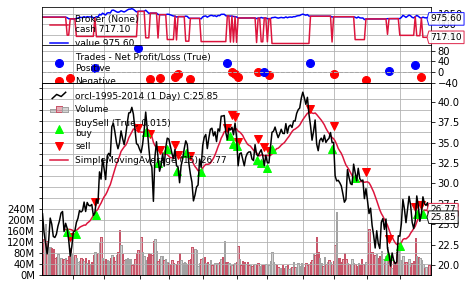

In [11]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import sys  # To find out the script name (in argv[0])
%matplotlib inline 
import matplotlib.pyplot as plt

# Import the backtrader platform
import backtrader as bt

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        # bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        # bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
        #                                     subplot=True)
        # bt.indicators.StochasticSlow(self.datas[0])
        # bt.indicators.MACDHisto(self.datas[0])
        # rsi = bt.indicators.RSI(self.datas[0])
        # bt.indicators.SmoothedMovingAverage(rsi, period=10)
        # bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2i' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2i' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm,
                          order.executed.size))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    datapath = '/Users/d062864/Documents/01_code/pythonStarter/data/orcl-1995-2014.txt'
    # datapath = os.path.join(modpath, '/orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.plot()

<IPython.core.display.Javascript object>

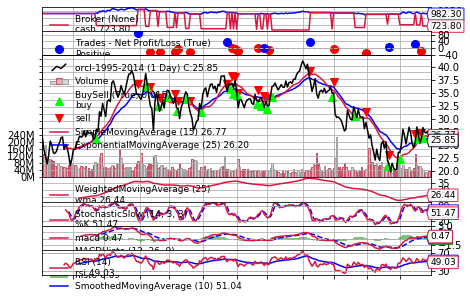

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
p=cerebro.plot()
# plt.plot([1,2,3])